In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt, prod

# Direct Random Weighted Graphs


In [2]:
# Setting the seed
np.random.seed(2060685 + 2139662 + 2139221)

### Random Weight
This class is responsible to manage the edge behaviour

In [3]:
class RandomWeight:
    def __init__(self, mean, standard_deviation):
        self.mean = mean
        self.standard_deviation = standard_deviation
        self.variance = standard_deviation**2

    def __str__(self):
        return f"N({round(self.mean, 2)}, {round(self.variance, 2)})"

    def sample(self):
        return np.random.normal(loc = self.mean, scale = self.standard_deviation)
    
    def cdf(self, x):
        return norm.cdf(x, loc = self.mean, scale = self.standard_deviation)

    def pdf(self, x):
        return norm.pdf(x, loc = self.mean, scale = self.standard_deviation)

### DRWG
This class will represent our model

In [4]:
class DRWG:
    # Default values
    _N = 10
    _P = .3
    _MEAN_INTERVAL = (1, 100)
    _STD_INTERVAL = (sqrt(0.1), sqrt(0.4))
    _SEED = 2060685 + 2139662 + 2139221
    _TITLE = "Graph"
    _FIGSIZE = (10, 10)
    _WITH_LABELS = True
    _NODE_COLOR = "lightblue"
    _EDGE_COLOR = "gray"
    _NODE_SIZE = 500
    _FONT_SIZE = 10
    _ARROWSIZE = 20
    _FONT_COLOR = "red"

    def __init__(self, n = _N, p = _P, seed = _SEED):
        self.graph : nx.DiGraph = nx.fast_gnp_random_graph(n, p, seed, directed = True)
        for u, v in self.graph.edges():
            random_mean = np.random.uniform(self._MEAN_INTERVAL[0], self._MEAN_INTERVAL[1])
            random_std = np.random.uniform(self._STD_INTERVAL[0], self._STD_INTERVAL[1])
            
            rw = RandomWeight(random_mean, random_std)
            
            self.graph[u][v]['label'] = rw.__str__()
            self.graph[u][v]['random_weight'] = rw
        
        # Nodes position layout
        self.layout = nx.spring_layout(self.graph, seed)

    def plot_graph(self, graph, title = _TITLE, figsize = _FIGSIZE, seed = _SEED, with_labels = _WITH_LABELS, node_color = _NODE_COLOR, edge_color = _EDGE_COLOR, node_size = _NODE_SIZE, font_size = _FONT_SIZE, font_color = _FONT_COLOR, arrowsize = _ARROWSIZE):
        # Draws the graph
        plt.figure(figsize = figsize)
        
        # Draws nodes and arcs
        nx.draw(graph, self.layout, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, arrowsize = arrowsize)

        # Disegna le etichette degli archi
        nx.draw_networkx_edge_labels(graph, self.layout, edge_labels = nx.get_edge_attributes(graph, 'label'), font_color = font_color, font_size = font_size)

        plt.title("Graph")
        plt.show()
    
    def plot(self, title = _TITLE, figsize = _FIGSIZE, seed = _SEED, with_labels = _WITH_LABELS, node_color = _NODE_COLOR, edge_color = _EDGE_COLOR, node_size = _NODE_SIZE, font_size = _FONT_SIZE, font_color = _FONT_COLOR, arrowsize = _ARROWSIZE):
        self.plot_graph(self.graph, title = title, figsize = figsize, seed = seed, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, font_color = font_color, arrowsize = arrowsize)

    def sample(self) -> nx.DiGraph:
        sample_graph = nx.DiGraph()
        
        for u, v in self.graph.edges():
            sample = self.graph.get_edge_data(u, v)["random_weight"].sample()
            sample_graph.add_edge(u, v, label = round(sample, 2), random_weight = sample)

        return sample_graph

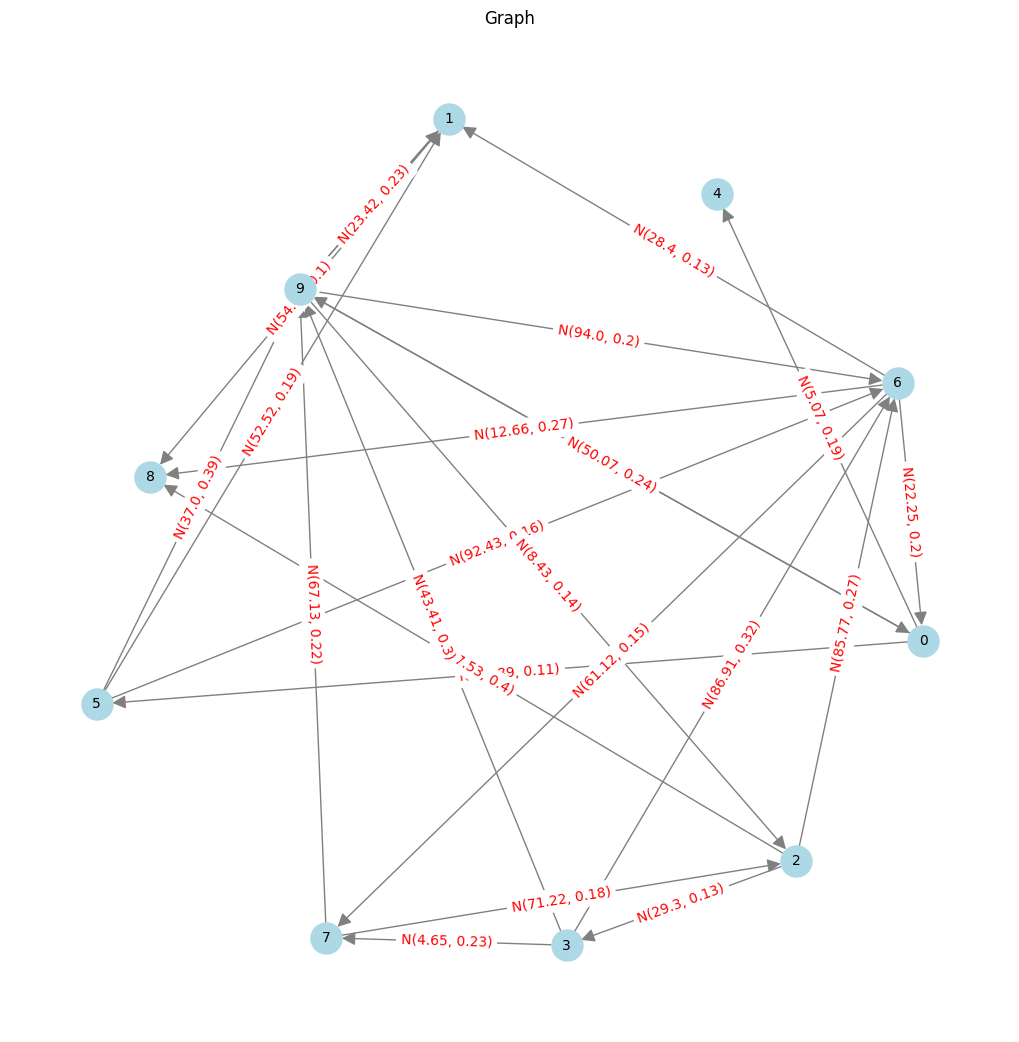

In [5]:
# Create an istance of the class
g1 = DRWG()

# Plot the model
g1.plot()

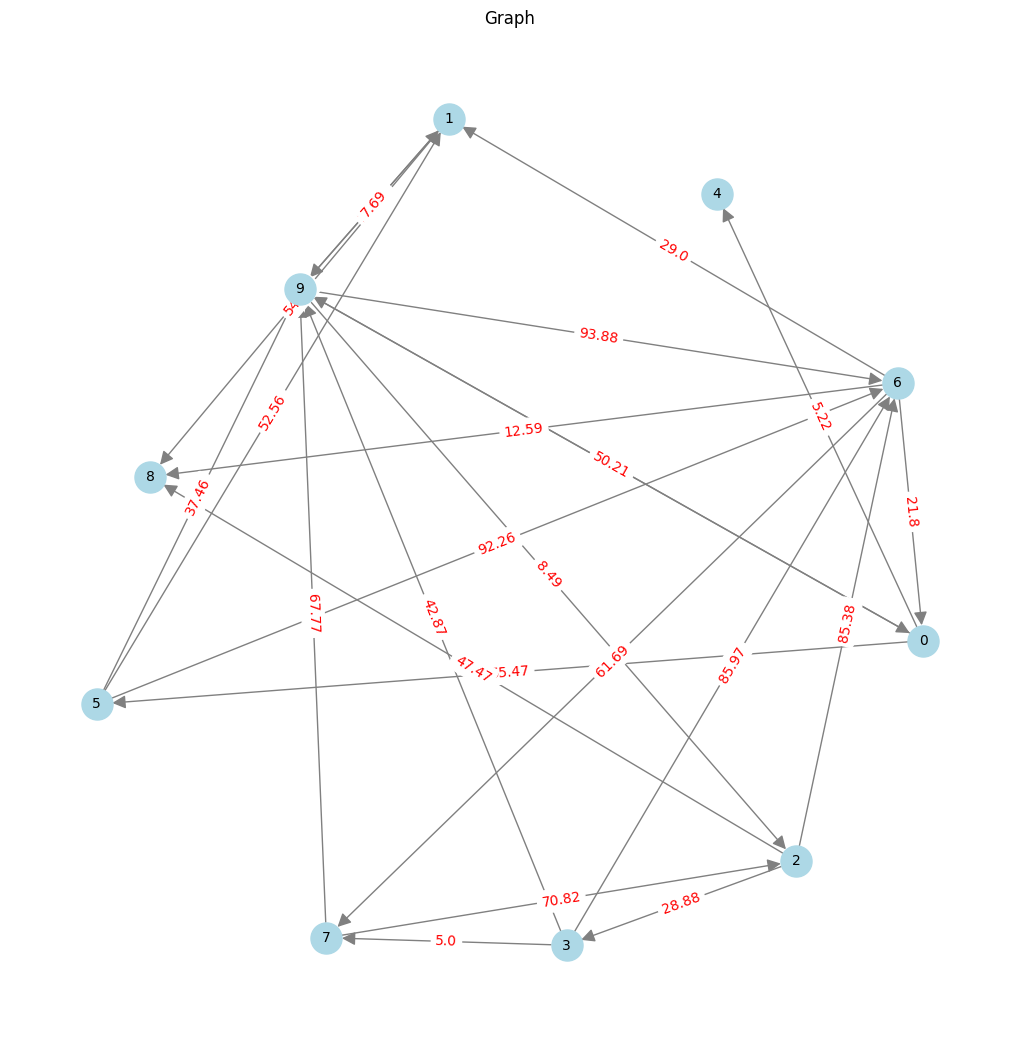

In [6]:
# Sample from the model
sample = g1.sample()

# Plot the sample
g1.plot_graph(sample)

## Gumbel distribution
The Gumbel distribution is often used to model the distribution of the maximum (or the minimum) of a set of r.v.

In [7]:
class GUMB:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws
        self.mu = max(rw.mean for rw in self.random_weights)
        self.beta = sqrt(sum(rw.variance for rw in self.random_weights))
        self.expectation = self.mu + np.euler_gamma * self.beta

In [46]:
mx = GUMB([RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(10)])

print(f"Expectation: {mx.expectation}")

Expectation: 4.039682389764314


## Exact distribution
Even if the Gumbel distribution is used in some models, it is an approximation.
We will study how well it approximate w.r.t. the true distribution

In [37]:
from scipy.stats import norm
from scipy.integrate import quad

class MAX:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws

    def cdf(self, x):
        return prod(rw.cdf(x) for rw in self.random_weights)

    def pdf(self, x):
        return self.cdf(x) * sum((rw.pdf(x) / (rw.cdf(x) + 1e-17)) / rw.standard_deviation for rw in self.random_weights)

    def get_expectation(self):
        return quad(lambda x: x * self.pdf(x), a = -np.inf, b = np.inf)

In [40]:
mx = MAX([RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(10)])

result, error = mx.get_expectation()

print(f"Numerical integration result: {result}")
print(f"Estimated error: {error}")

Numerical integration result: 18.91233362077405
Estimated error: 4.751035924434779e-08


# Brutta

In [14]:
# from sympy import symbols, integrate, exp, oo, sqrt, pi# Definisci la variabile simbolica
# x = symbols('x')

# phi = lambda mu, sigma: 0.5 * (1 + exp(-(x - mu)**2 / (2 * sigma**2)) / (sqrt(2 * pi) * sigma))
# cdf_product = prod(phi(rv.mean, rv.standard_deviation) for rv in random_vars)
# result = integrate(cdf_product, (x, 1, 2))

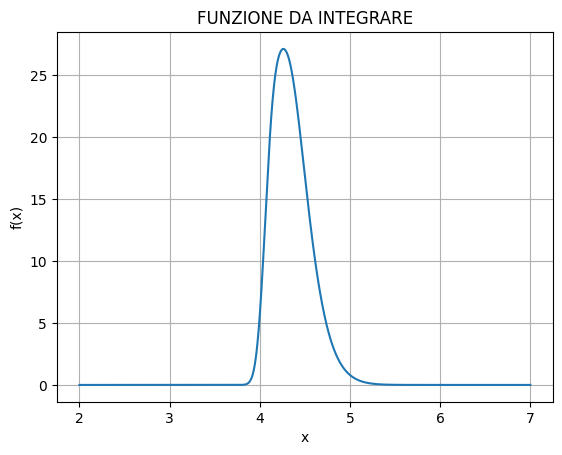

In [51]:
import matplotlib.pyplot as plt

# Plot the function over the finite range
x_vals = np.linspace(2, 7, 1000)
y_vals = [function_to_integrate(x) for x in x_vals]


plt.plot(x_vals, y_vals)
plt.title("FUNZIONE DA INTEGRARE")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

## Random Weighted Degree

In un sample,

$ d_w^+(u) = \sum_{v \in \mathcal{N}(u)} w(u, v) $  
$ d_w^-(u) = \sum_{v \in \mathcal{N}(u)} w(v, u) $

dato che $ W(u, v) \sim \mathcal{N}(\mu_{(u, v)}, \sigma^2_{(u, v)}) $  
$ d_W^-(u) = \sum_{v \in \mathcal{N}(u)} W(v, u) \sim \mathcal{N}(\sum_{v \in \mathcal{N}(u)} \mu_{(v, u)}, \sigma^2_{(v, u)})$  

$P_r(d_W^-(u)\leq 5) = \Phi(5) $

$P_r(1 \leq d_W^-(u)\leq 5) = \Phi(5) -  \Phi(1)$

$d^+_w(G) = max(d_w^+(u))$

In [19]:
def sample_degree(n_samples):
  d_in_total = {}
  d_out_total = {}
  for v in g1.graph.nodes():
    d_in_total.update({v: 0})
    d_out_total.update({v: 0})


  for i in range(int(n_samples)):
    sample = g1.sample()
    in_degrees = sample.in_degree(weight='random_weight')
    out_degrees = sample.out_degree(weight='random_weight')
    for v in g1.graph.nodes():
      d_in_total[v] += in_degrees[v]
      d_out_total[v] += out_degrees[v] 

  for v in d_in_total:
    d_in_total[v] = d_in_total[v] / n_samples
    d_out_total[v] = d_out_total[v] / n_samples
    
  return (d_in_total, d_out_total)


In [20]:
sample_degree(100000)

({0: 4.841849063140204,
  1: 7.083553031111559,
  2: 5.144542680826768,
  3: 2.1347329161661346,
  4: 1.1795857932396747,
  5: 3.217674628101389,
  6: 18.31239436133169,
  7: 4.581865121273752,
  8: 7.504346363792388,
  9: 13.755290853722324},
 {0: 8.024723958299964,
  1: 4.417600663826643,
  2: 9.44673659295496,
  3: 8.287566073503273,
  4: 0.0,
  5: 10.263127252875467,
  6: 8.856798996410022,
  7: 7.526602958468819,
  8: 0.0,
  9: 10.93267831636667})

N_SAMPLE -> 2
N_SAMPLE -> 1113
N_SAMPLE -> 2224
N_SAMPLE -> 3335
N_SAMPLE -> 4446
N_SAMPLE -> 5557
N_SAMPLE -> 6668
N_SAMPLE -> 7779
N_SAMPLE -> 8890
N_SAMPLE -> 10001


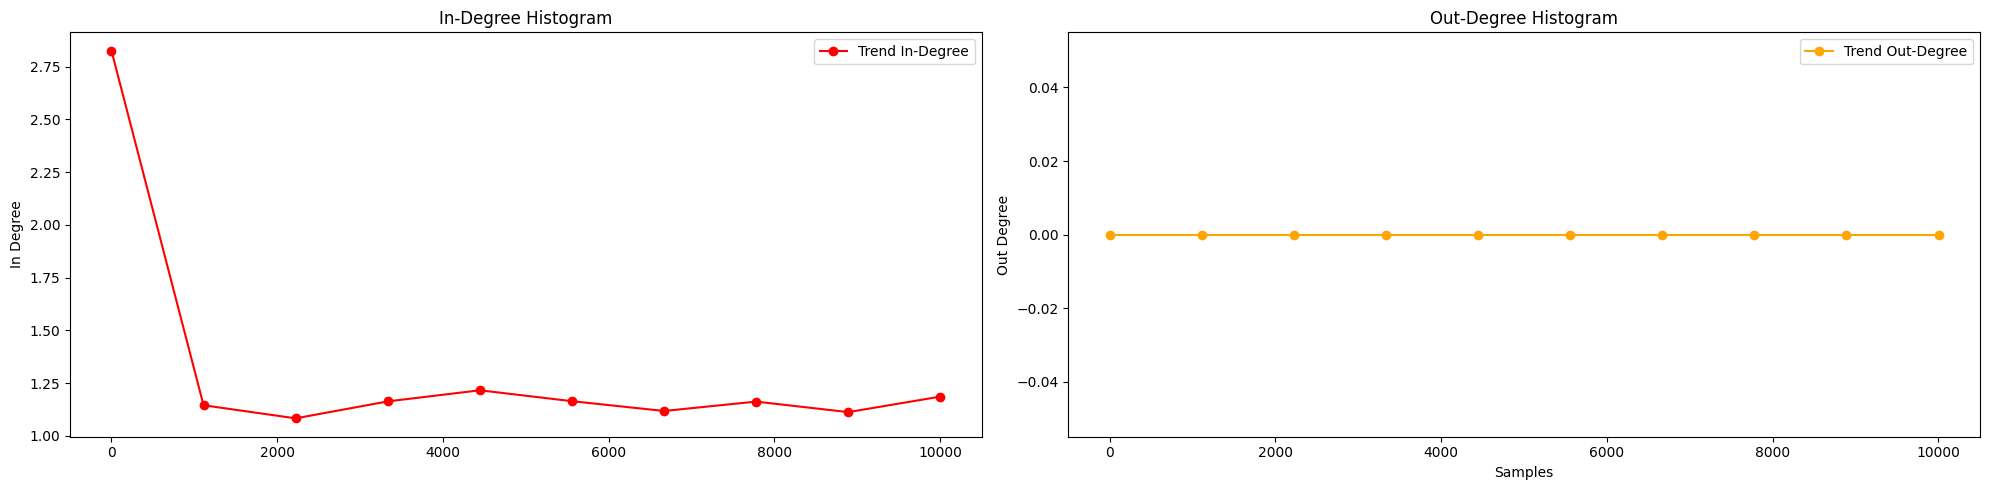

In [21]:
analyzed_node = 4

min_iterations = 1
max_iterations = 10000
step = 10

in_degree_list = []
out_degree_list = []

iterations = [1] + np.linspace(min_iterations, max_iterations, num=step)
for k_iterations in iterations:
    print("N_SAMPLE ->", int(k_iterations))
    in_degrees, out_degrees = sample_degree(k_iterations)
    in_degree_list.append(in_degrees[analyzed_node])
    out_degree_list.append(out_degrees[analyzed_node])


# - Aggiungi linea di media teorica
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
#axs[0].bar(iterations, in_degree_list, color='blue', alpha=0.7, label='In-Degree')
axs[0].plot(iterations, in_degree_list, color='red', marker='o', label='Trend In-Degree')
axs[0].set_title('In-Degree Histogram')
axs[0].set_ylabel('In Degree')
axs[0].legend()

#axs[1].bar(iterations, out_degree_list, color='green', alpha=0.7, label='Out-Degree')
axs[1].plot(iterations, out_degree_list, color='orange', marker='o', label='Trend Out-Degree')
axs[1].set_title('Out-Degree Histogram')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Out Degree')
axs[1].legend()

plt.tight_layout()
plt.show()

In [22]:
# - Iterazioni che dipendono da formula di parpa ma in generale anche da grado non pesato e varianza totale

in_edges = g1.graph.in_edges(analyzed_node, data=True)

mean = sum(edge[2]['random_weight'].mean for edge in in_edges) 
std_dev = sqrt(sum(edge[2]['random_weight'].standard_deviation**2 for edge in in_edges))

margin_error = 0.05
confidence_value = 1.96

K_NEEDED = ceil(((confidence_value * std_dev) / margin_error)**2)
print(K_NEEDED)
sample_degree(K_NEEDED)

11849


({0: 4.831506755477699,
  1: 7.109972882545627,
  2: 5.17227565484351,
  3: 2.159960912964511,
  4: 1.1671067722171005,
  5: 3.2345088611926536,
  6: 18.324057845336934,
  7: 4.5779404376876025,
  8: 7.584146548328656,
  9: 13.836425562555027},
 {0: 7.9829010625536085,
  1: 4.477879113214939,
  2: 9.457298901565022,
  3: 8.352693140690166,
  4: 0.0,
  5: 10.23063622315527,
  6: 8.90460579395502,
  7: 7.592898753409521,
  8: 0.0,
  9: 10.998989244605767})

In [23]:
in_degrees = []
 
for v in g1.graph.nodes():
    in_edges = g1.graph.in_edges(v, data=True)
    mean = sum(edge[2]['random_weight'].mean for edge in in_edges) 
    std_dev = sqrt(sum(edge[2]['random_weight'].standard_deviation**2 for edge in in_edges))
    rw = RandomWeight(mean=mean, standard_deviation=std_dev)
    in_degrees.append(rw)
    
get_expectation_gumbel(in_degrees)

26.61484002879813

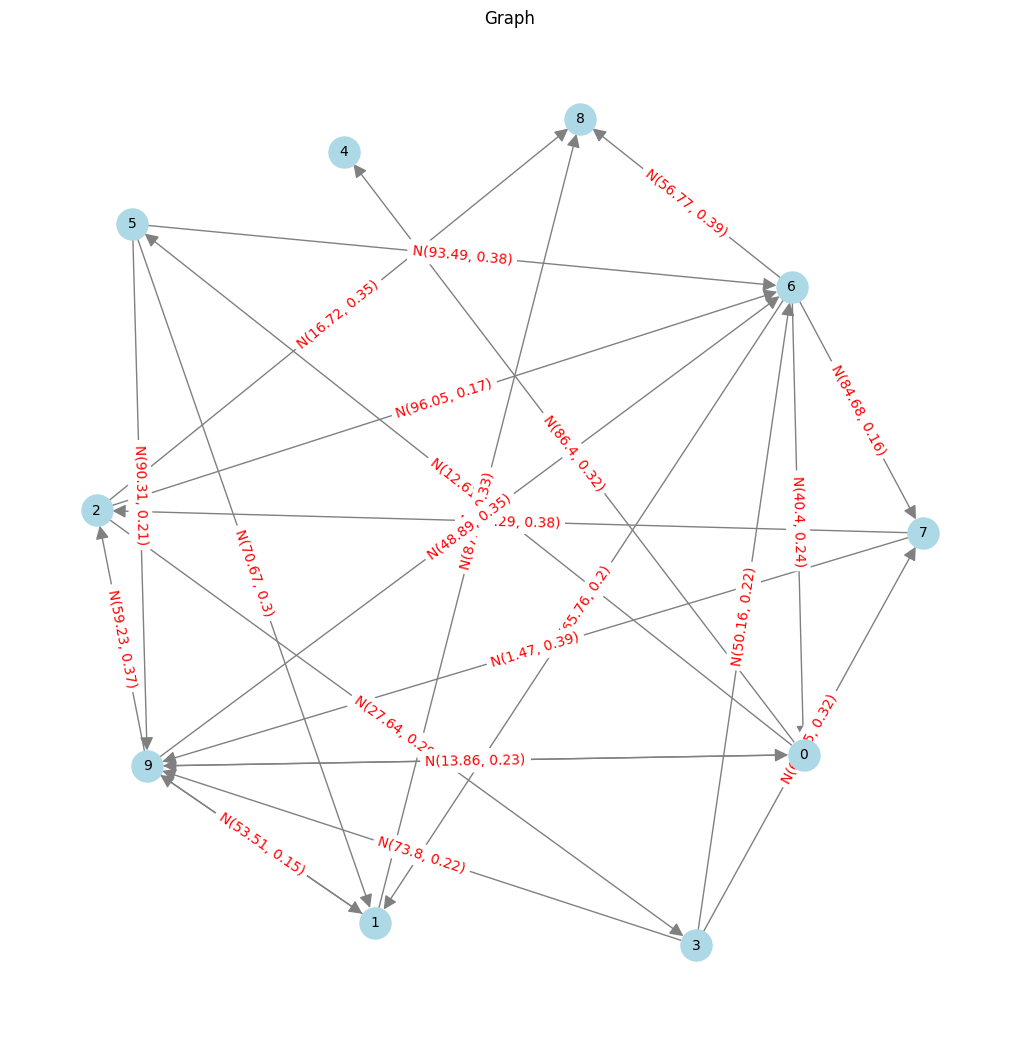

In [21]:
g1 = DRWG()
g1.plot()

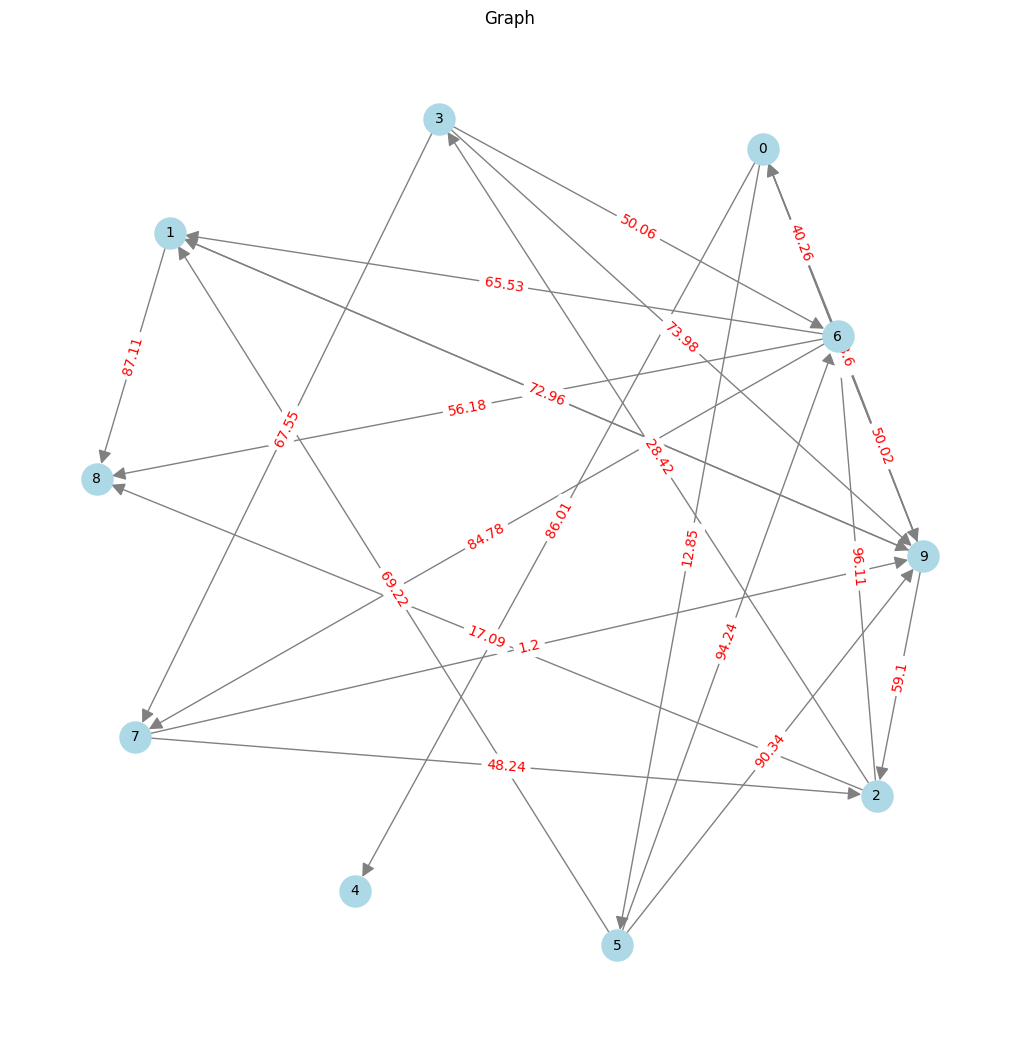

In [24]:
g1.plot_graph(g1.sample())

In [ ]:
# TODO:
# Stampare grafico distribuzione di gumbel 
# e il Fm(m) (produttoria) della formula
# per fare la verifica
# (cross-entropy per la similarità)